In [1]:
# === Bibliotecas padrão ===
from pathlib import Path
import importlib

# === Bibliotecas de terceiros ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import compute_sample_weight

import joblib

# === Módulos locais ===
import sys
import os

# Caminho absoluto até a pasta src
src_path = r"C:\Users\Camilo_Bica\data_science\consultoria\acelerador_petrobras\notebooks\src"

if src_path not in sys.path:
    sys.path.append(src_path)
    
# Garante que a pasta atual (notebooks/) esteja no sys.path
notebooks_dir = os.path.abspath(os.getcwd())
if notebooks_dir not in sys.path:
    sys.path.append(notebooks_dir)

# Agora importa diretamente SEM prefixo
import leadscore_plot
importlib.reload(leadscore_plot)

from leadscore_plot import (
    plot_comparativo_leads_alunos,
    plot_histograma_leadscore,
    plot_probabilidade_conversao_vs_score
)

# === Configuração de visualização ===
cores = plt.get_cmap('Accent').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

In [2]:
# === Imports
import gspread
from gspread_dataframe import get_as_dataframe
import os
from dotenv import load_dotenv
from google.oauth2 import service_account

# === Carregar variáveis de ambiente
load_dotenv()

# === Autenticação
credenciais_path = os.getenv("GOOGLE_CREDENTIALS_PATH")
scopes = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]
creds = service_account.Credentials.from_service_account_file(
    credenciais_path,
    scopes=scopes
)
client = gspread.authorize(creds)

# === Função para carregar direto do Google Sheets
def carregar_aba(sheet_id, aba_nome="Dados"):
    planilha = client.open_by_key(sheet_id)
    aba = planilha.worksheet(aba_nome)
    df = pd.DataFrame(aba.get_all_records())
    return df

# === IDs fixos das suas planilhas
id_pesquisa_captacao = "1ukLwu8SoP0U3uirB6w1Ca3TPEITY50c558xNUUN3kj4"
id_pesquisa_aluno = "1GDCAa1fiflDIBnRY9rrdY9ghKwS6DPzxIG9FYGZEsQU"
id_invest_trafego = "1477LAemTkMN1YTFdRJkLMaDLPZEiJ3vvtqwduemHXD4"

# === Carregar os dados direto da nuvem
df_leads = carregar_aba(id_pesquisa_captacao)
df_alunos = carregar_aba(id_pesquisa_aluno)
df_invest_trafego = carregar_aba(id_invest_trafego)

# === Garantir cópias para segurança
df_leads = df_leads.copy()
df_alunos = df_alunos.copy()

# === Criar variável target 'comprou'
df_leads["comprou"] = df_leads["email"].isin(df_alunos["email"]).astype(int)

In [3]:
df_leads.drop(columns=['email']).head()

,data,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,lancamentos,utm_source,utm_campaign,utm_medium,utm_content,comprou
0,2025-04-07 0:00:00,38-45,Técnica,Já sou funcionário terceirizado do sistema Pet...,De 3.000 a 5.000,Nível técnico completo,Como participar do processo seletivo,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D,ADS_006_ANUNCIO PETRO 06,0
1,2025-04-07 0:00:00,38-45,Técnica,Desempregado(a),Estou desempregado(a),Nível técnico completo,Assunto específico que cai na prova?,Dificuldade em aprender!,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,0
2,2025-04-07 0:00:00,28-32,Técnica,Funcionário público,De 1.000 a 3.000,Ensino médio completo,Nas perguntas,Concentração,SSP-L12,,,,,0
3,2025-04-07 0:00:00,18-22,Técnica,Desempregado(a),Estou desempregado(a),Ensino médio completo,Como estudar,Constância,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_006_ANUNCIO PETRO 06,0
4,2025-04-07 0:00:00,23-27,Técnica,Desempregado(a),De 1.000 a 3.000,Ensino médio completo,Qual tempo de curso,Nenhuma,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_006_ANUNCIO PETRO 06,0


In [4]:
df_alunos.drop(columns=['email']).head()

,data,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,lancamentos,utm_source,utm_campaign,utm_medium,utm_content
0,2025-04-07 0:00:00,23-27,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,O que estudar,Montar um planejamento de estudos,SSP-L12,,,,
1,2025-04-07 0:00:00,28-32,Técnica,Funcionário de empresa privada,De 5.000 a 10.000,Nível técnico completo,Assuntos da prova,"Cronograma, oq estudar",SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | SEGUIDORES,ADS_007_ANUNCIO PETRO 07
2,2025-04-07 0:00:00,33-37,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,"Preciso ter algum curso técnico, ou só o ensin...","Não sei por onde começar, nem os conteúdos que...",SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_003_ANUNCIO PETRO 03
3,2025-04-07 0:00:00,28-32,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,Em qual cidade irei fazer o concurso?,Não sei o que estudar,SSP-L12,Youtube,,Descricao,
4,2025-04-07 0:00:00,28-32,Técnica,Desempregado(a),De 1.000 a 3.000,Ensino superior completo,Quando vai sair o edital,Foco,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_007_ANUNCIO PETRO 07


In [5]:
colunas_excluir = ["data", "email"]

for col in df_leads.select_dtypes(include=["category", "object"]).columns:
    if col not in colunas_excluir:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_leads[col].value_counts(dropna=False))


====== VARIÁVEL: IDADE ======

idade
23-27         7257
18-22         6785
28-32         5913
38-45         5438
33-37         4755
46-52         2474
53 ou mais     992
Name: count, dtype: int64

====== VARIÁVEL: NÍVEL ======

nível
Técnica     25443
Superior     8171
Name: count, dtype: int64

====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======

situação profissional
Funcionário de empresa privada                          14301
Autônomo                                                 8126
Desempregado(a)                                          7651
Funcionário público                                      2317
Empresário                                                672
Já sou funcionário terceirizado do sistema Petrobras      547
Name: count, dtype: int64

====== VARIÁVEL: RENDA ======

renda
De 1.000 a 3.000         16983
De 3.000 a 5.000          6276
De 0 a 1.000              4262
Estou desempregado(a)     3829
De 5.000 a 10.000         1954
Mais de 10.000             310
Name: count

In [6]:
for col in df_alunos.select_dtypes(include=["category", "object"]).columns:
    if col not in colunas_excluir:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_alunos[col].value_counts(dropna=False))


====== VARIÁVEL: IDADE ======

idade
23-27         49
38-45         36
28-32         35
33-37         31
46-52         22
18-22         17
53 ou mais     6
Name: count, dtype: int64

====== VARIÁVEL: NÍVEL ======

nível
Técnica     165
Superior     31
Name: count, dtype: int64

====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======

situação profissional
Funcionário de empresa privada                          99
Desempregado(a)                                         40
Autônomo                                                33
Empresário                                              12
Funcionário público                                     10
Já sou funcionário terceirizado do sistema Petrobras     2
Name: count, dtype: int64

====== VARIÁVEL: RENDA ======

renda
De 1.000 a 3.000         79
De 3.000 a 5.000         55
De 5.000 a 10.000        27
Estou desempregado(a)    22
De 0 a 1.000             10
Mais de 10.000            3
Name: count, dtype: int64

====== VARIÁVEL: ESCOLARIDADE ======



In [7]:
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33614 entries, 0 to 33613
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   data                   33614 non-null  object
 1   email                  33614 non-null  object
 2   idade                  33614 non-null  object
 3   nível                  33614 non-null  object
 4   situação profissional  33614 non-null  object
 5   renda                  33614 non-null  object
 6   escolaridade           33614 non-null  object
 7   duvida                 33614 non-null  object
 8   dificuldade            33614 non-null  object
 9   lancamentos            33614 non-null  object
 10  utm_source             33614 non-null  object
 11  utm_campaign           33614 non-null  object
 12  utm_medium             33614 non-null  object
 13  utm_content            33614 non-null  object
 14  comprou                33614 non-null  int32 
dtypes: int32(1), object

In [8]:
df_alunos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   data                   196 non-null    object
 1   email                  196 non-null    object
 2   idade                  196 non-null    object
 3   nível                  196 non-null    object
 4   situação profissional  196 non-null    object
 5   renda                  196 non-null    object
 6   escolaridade           196 non-null    object
 7   duvida                 196 non-null    object
 8   dificuldade            196 non-null    object
 9   lancamentos            196 non-null    object
 10  utm_source             196 non-null    object
 11  utm_campaign           196 non-null    object
 12  utm_medium             196 non-null    object
 13  utm_content            196 non-null    object
dtypes: object(14)
memory usage: 21.6+ KB


In [9]:
def gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col, col_lancamento="lancamentos", min_leads=5):
    """
    Calcula lift por categoria com base em lançamentos,
    usando médias ponderadas e sem warnings futuros.
    """

    ciclos = pd.Index(df_alunos[col_lancamento].dropna().unique()).union(
        df_leads[col_lancamento].dropna().unique()
    )

    linhas = []

    for ciclo in ciclos:
        leads_ciclo = df_leads[df_leads[col_lancamento] == ciclo]
        alunos_ciclo = df_alunos[df_alunos[col_lancamento] == ciclo]

        cont_leads = leads_ciclo[col].value_counts().rename("qtd_leads")
        cont_alunos = alunos_ciclo[col].value_counts().rename("qtd_alunos")

        total_leads = cont_leads.sum()
        total_alunos = cont_alunos.sum()

        perc_leads = (cont_leads / total_leads * 100).rename("percentual_leads")
        perc_alunos = (cont_alunos / total_alunos * 100).rename("percentual_alunos")

        tabela = pd.concat([cont_leads, cont_alunos, perc_leads, perc_alunos], axis=1).fillna(0)
        tabela["lancamento"] = ciclo
        tabela.reset_index(inplace=True)
        tabela.rename(columns={"index": col}, inplace=True)

        tabela_validas = tabela[tabela["qtd_leads"] >= min_leads].copy()
        tabela_validas["lift"] = tabela_validas.apply(
            lambda row: row["percentual_alunos"] / row["percentual_leads"] if row["percentual_leads"] > 0 else 0,
            axis=1
        )
        tabela_validas["score"] = (tabela_validas["lift"] * tabela_validas["qtd_alunos"]).round(2)
        linhas.append(tabela_validas)

    df_validado = pd.concat(linhas, ignore_index=True)

    # >>> CORREÇÃO AQUI <<<

    # Primeiro faz o groupby
    agrupado = df_validado.groupby(col, observed=True)

    # Depois aplica manualmente
    resultados = []
    for categoria, grupo in agrupado:
        qtd_leads = grupo["qtd_leads"].sum()
        qtd_alunos = grupo["qtd_alunos"].sum()
        percentual_leads = (grupo["percentual_leads"] * grupo["qtd_leads"]).sum() / grupo["qtd_leads"].sum()
        percentual_alunos = (grupo["percentual_alunos"] * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0
        lift_vals = grupo["lift"].replace([np.inf, -np.inf], 0)
        lift = (lift_vals * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0

        score_vals = grupo["score"].replace([np.inf, -np.inf], 0)
        score = score_vals.sum()

        resultados.append({
            col: categoria,
            "qtd_leads": round(qtd_leads, 2),
            "qtd_alunos": round(qtd_alunos, 2),
            "percentual_leads": round(percentual_leads, 2),
            "percentual_alunos": round(percentual_alunos, 2),
            "lift": round(lift, 2),
            "score": round(score, 2)
        })

    tabela_final = pd.DataFrame(resultados).set_index(col)

    # Anotação
    todas_categorias = set(df_leads[col].dropna().unique()).union(set(df_alunos[col].dropna().unique()))
    categorias_na_tabela = set(tabela_final.index)
    categorias_descartadas = todas_categorias - categorias_na_tabela

    # Forçar lift específico para uma categoria
    if col == "renda" and "De 1.000 a 3.000" in tabela_final.index:
        tabela_final.loc["De 1.000 a 3.000", "lift"] = 0.5
        tabela_final.loc["De 1.000 a 3.000", "score"] = round(
            tabela_final.loc["De 1.000 a 3.000", "qtd_alunos"] * 0.5, 2
        )

    # Forçar lift específico para uma categoria
    if col == "renda" and "Estou desempregado(a)" in tabela_final.index:
        tabela_final.loc["Estou desempregado(a)", "lift"] = 0.5
        tabela_final.loc["Estou desempregado(a)", "score"] = round(
            tabela_final.loc["Estou desempregado(a)", "qtd_alunos"] * 0.5, 2
        )

    return tabela_final.sort_values(by="score", ascending=False)

In [10]:
# Lista das colunas a serem avaliadas
features_alunos = [
    "renda",
    "escolaridade",
    "idade",
    "nível",
    "situação profissional"
]

for coluna in features_alunos:
    print(f"\n=== TABELA: {coluna} ===")
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, coluna)

    # Colunas a somar (ignorando 'lift' e 'score')
    colunas_para_somar = [
        col for col in tabela.columns
        if col not in ["lift", "score", "percentual_alunos", "percentual_leads"]
        and pd.api.types.is_numeric_dtype(tabela[col])
    ]

    # Criar linha de total
    totais = tabela[colunas_para_somar].sum().to_frame().T
    totais.index = ["Total"]

    # Preencher colunas restantes com vazio ou marcador
    for col in tabela.columns:
        if col not in totais.columns:
            totais[col] = "-"

    # Reordenar para manter consistência
    totais = totais[tabela.columns]

    # Concatenar com a tabela original
    tabela_com_total = pd.concat([tabela, totais], axis=0)

    display(tabela_com_total)


=== TABELA: renda ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
De 3.000 a 5.000,6276.0,55.0,18.67,28.06,1.5,82.57
De 5.000 a 10.000,1954.0,27.0,5.86,13.78,2.26,61.01
De 1.000 a 3.000,16983.0,79.0,50.56,40.31,0.5,39.5
Estou desempregado(a),3829.0,22.0,11.42,11.22,0.5,11.0
Mais de 10.000,310.0,3.0,0.94,1.53,1.56,4.68
De 0 a 1.000,4262.0,10.0,12.68,5.1,0.4,4.01
Total,33614.0,196.0,-,-,-,-



=== TABELA: escolaridade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
Ensino superior completo,4740.0,61.0,14.61,31.12,2.01,122.49
Nível técnico completo,3170.0,39.0,9.55,19.9,1.99,77.71
Ensino médio completo,19807.0,72.0,59.22,36.73,0.65,46.61
Ensino superior incompleto,4442.0,22.0,13.31,11.22,0.81,17.88
Nível técnico incompleto,1455.0,2.0,4.44,1.02,0.26,0.51
Total,33614.0,196.0,-,-,-,-



=== TABELA: idade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
23-27,7257.0,49.0,21.69,25.0,1.2,58.86
38-45,5438.0,36.0,16.28,18.37,1.09,39.2
28-32,5913.0,35.0,17.59,17.86,1.02,35.71
33-37,4755.0,31.0,14.15,15.82,1.11,34.28
46-52,2474.0,22.0,7.46,11.22,1.44,31.59
18-22,6785.0,17.0,20.28,8.67,0.45,7.57
53 ou mais,992.0,6.0,3.04,3.06,0.95,5.7
Total,33614.0,196.0,-,-,-,-



=== TABELA: nível ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
Técnica,25443.0,165.0,75.7,84.18,1.11,182.36
Superior,8171.0,31.0,24.34,15.82,0.66,20.57
Total,33614.0,196.0,-,-,-,-



=== TABELA: situação profissional ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
Funcionário de empresa privada,14301.0,99.0,42.55,50.51,1.19,117.69
Desempregado(a),7651.0,40.0,22.77,20.41,0.89,35.62
Empresário,672.0,12.0,2.02,6.12,2.9,34.85
Autônomo,8126.0,33.0,24.23,16.84,0.71,23.56
Funcionário público,2317.0,10.0,6.93,5.1,0.71,7.13
Já sou funcionário terceirizado do sistema Petrobras,547.0,2.0,1.66,1.02,0.58,1.16
Total,33614.0,196.0,-,-,-,-


In [11]:
# Função auxiliar para listar valores únicos, já aplicando strip
def listar_valores_unicos(df, coluna):
    return sorted({str(v).strip() for v in df[coluna].dropna().unique()})

# Loop pelas variáveis
for coluna in features_alunos:
    print(f"\n\n=== VARIÁVEL: {coluna.upper()} ===")

    valores_leads = listar_valores_unicos(df_leads, coluna)
    valores_alunos = listar_valores_unicos(df_alunos, coluna)

    print("\n🎯 Valores em df_leads:")
    for v in valores_leads:
        print(f"- '{v}'")

    print("\n🎯 Valores em df_alunos:")
    for v in valores_alunos:
        print(f"- '{v}'")

    print("\n🚨 Categorias nos leads mas não nos alunos:")
    diferenca_leads = set(valores_leads) - set(valores_alunos)
    print(diferenca_leads if diferenca_leads else "Nenhuma diferença.")

    print("\n🚨 Categorias nos alunos mas não nos leads:")
    diferenca_alunos = set(valores_alunos) - set(valores_leads)
    print(diferenca_alunos if diferenca_alunos else "Nenhuma diferença.")



=== VARIÁVEL: RENDA ===

🎯 Valores em df_leads:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'

🎯 Valores em df_alunos:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'

🚨 Categorias nos leads mas não nos alunos:
Nenhuma diferença.

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: ESCOLARIDADE ===

🎯 Valores em df_leads:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'

🎯 Valores em df_alunos:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'

🚨 Categorias nos leads mas não nos alunos:
Nenhuma diferença.

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: IDADE ===

🎯 Valores em df_leads:
- '18

In [12]:
def gerar_distribuicao_por_categoria(df_leads, df_alunos, col):
    """
    Gera a tabela com contagem e percentual de leads e alunos por categoria, sem lift ou score.

    Retorno:
    -------
    pd.DataFrame com colunas: categoria, qtd_leads, qtd_alunos, percentual_leads, percentual_alunos
    """
    contagem_leads = df_leads[col].value_counts().rename("qtd_leads")
    contagem_alunos = df_alunos[col].value_counts().rename("qtd_alunos")

    percentual_leads = (contagem_leads / contagem_leads.sum() * 100).round(2).rename("percentual_leads")
    percentual_alunos = (contagem_alunos / contagem_alunos.sum() * 100).round(2).rename("percentual_alunos")

    tabela = pd.concat([contagem_leads, contagem_alunos, percentual_leads, percentual_alunos], axis=1).fillna(0)
    tabela = tabela.astype({"qtd_leads": int, "qtd_alunos": int})
    return tabela

In [13]:
for coluna in features_alunos:
    print(f"\n====== VARIÁVEL: {coluna.upper()} ======\n")

    for lanc in sorted(df_leads["lancamentos"].dropna().unique()):
        print(f"\n--- Lançamento: {lanc} ---")
        
        leads_subset = df_leads[df_leads["lancamentos"] == lanc]
        alunos_subset = df_alunos[df_alunos["lancamentos"] == lanc]

        if not leads_subset.empty and not alunos_subset.empty:
            tabela = gerar_distribuicao_por_categoria(leads_subset, alunos_subset, coluna)
            display(tabela)
        else:
            print("⚠️ Dados insuficientes para este lançamento.")


====== VARIÁVEL: RENDA ======




--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
De 1.000 a 3.000,13139,79,49.81,40.31
De 3.000 a 5.000,4930,55,18.69,28.06
De 0 a 1.000,3354,10,12.72,5.10
Estou desempregado(a),3086,22,11.70,11.22
De 5.000 a 10.000,1608,27,6.10,13.78
Mais de 10.000,259,3,0.98,1.53



--- Lançamento: SSP-L13 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: ESCOLARIDADE ======


--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
Ensino médio completo,14966,72,56.74,36.73
Ensino superior completo,4088,61,15.50,31.12
Ensino superior incompleto,3642,22,13.81,11.22
Nível técnico completo,2634,39,9.99,19.90
Nível técnico incompleto,1046,2,3.97,1.02



--- Lançamento: SSP-L13 ---


⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: IDADE ======


--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
23-27,5489,49,20.81,25.00
18-22,5137,17,19.48,8.67
28-32,4616,35,17.50,17.86
38-45,4449,36,16.87,18.37
33-37,3773,31,14.30,15.82
46-52,2062,22,7.82,11.22
53 ou mais,850,6,3.22,3.06



--- Lançamento: SSP-L13 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: NÍVEL ======


--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
nível,,,,
Técnica,20090,165,76.17,84.18
Superior,6286,31,23.83,15.82



--- Lançamento: SSP-L13 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======


--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
situação profissional,,,,
Funcionário de empresa privada,11207,99,42.49,50.51
Autônomo,6219,33,23.58,16.84
Desempregado(a),6044,40,22.91,20.41
Funcionário público,1887,10,7.15,5.10
Empresário,556,12,2.11,6.12
Já sou funcionário terceirizado do sistema Petrobras,463,2,1.76,1.02



--- Lançamento: SSP-L13 ---
⚠️ Dados insuficientes para este lançamento.


In [14]:
# 1. Gerar o novo score_map com base no lift ponderado
score_map = {}

for col in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col)
    
    # Normalizar apenas tirando espaços (NÃO converte para minúsculo)
    score_map[col] = {
        str(k).strip(): v
        for k, v in zip(tabela.index, tabela["score"])
    }

# 2. Função para calcular o score total (somando os scores das variáveis)
def calcular_leadscore_total(row, score_map):
    total = 0
    for var in score_map:
        resposta = str(row.get(var)).strip()  # Agora só strip, sem lower
        total += score_map[var].get(resposta, 0)
    return total

# 3. Aplicar aos leads
df_leads["leadscore_mapeado"] = df_leads.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)
df_alunos["leadscore_mapeado"] = df_alunos.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)

# 4. Verificações
print("LEADS")
print("Valores únicos:", df_leads["leadscore_mapeado"].nunique())
print("Score mínimo:", df_leads["leadscore_mapeado"].min())
print("Score máximo:", df_leads["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_leads["leadscore_mapeado"].value_counts().head())

print("\n" + "-" * 40 + "\n")

print("ALUNOS")
print("Valores únicos:", df_alunos["leadscore_mapeado"].nunique())
print("Score mínimo:", df_alunos["leadscore_mapeado"].min())
print("Score máximo:", df_alunos["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_alunos["leadscore_mapeado"].value_counts().head())

LEADS
Valores únicos: 1479
Score mínimo: 39.79
Score máximo: 563.97
Top 5 scores mais comuns:
leadscore_mapeado
445.02    1330
421.87    1063
393.73    1052
420.44     729
283.16     680
Name: count, dtype: int64

----------------------------------------

ALUNOS
Valores únicos: 133
Score mínimo: 92.64
Score máximo: 563.97
Top 5 scores mais comuns:
leadscore_mapeado
445.02    12
496.04     5
421.87     5
359.11     4
393.73     4
Name: count, dtype: int64


In [15]:
# Loop para todas as variáveis
for col in features_alunos:
    print(f"\n====== VARIÁVEL: {col.upper()} ======\n")

    valores_no_df = sorted(df_leads[col].dropna().unique())
    valores_no_map = sorted(score_map.get(col, {}).keys())

    print("❗Valores no df_leads:")
    for v in valores_no_df:
        print(f"- '{v}'")

    print("\n✅ Valores no score_map:")
    for v in valores_no_map:
        print(f"- '{v}'")

    print("\n" + "="*50)


====== VARIÁVEL: RENDA ======

❗Valores no df_leads:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'

✅ Valores no score_map:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'


====== VARIÁVEL: ESCOLARIDADE ======

❗Valores no df_leads:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'

✅ Valores no score_map:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'


====== VARIÁVEL: IDADE ======

❗Valores no df_leads:
- '18-22'
- '23-27'
- '28-32'
- '33-37'
- '38-45'
- '46-52'
- '53 ou mais'

✅ Valores no score_map:
- '18-22'
- '23-27'
- '28-32'
- '33-37'
- '38-45'
- '46-52'
- '53 ou mais'


====== VARIÁVEL: NÍVEL ======

❗Valores no df_leads:
- 'Superior'


In [16]:
# Calcular a média do leadscore total (já com lift ponderado como base)
media_score = df_alunos["leadscore_mapeado"].mean()

# Definir os limites com base em proporções da média
limite_a = media_score * 1.10
limite_b = media_score * 0.90
limite_c = media_score * 0.70
limite_d = media_score * 0.50

print(f"Média dos scores: {round(media_score)}")
print(f"Limite A (>= 110%): {round(limite_a)}")
print(f"Limite B (>=  90%): {round(limite_b)}")
print(f"Limite C (>=  70%): {round(limite_c)}")
print(f"Limite D (>=  50%): {round(limite_d)}")

# Função para classificar com base nos limites
def classificar_faixa(score):
    if score >= limite_a:
        return "A"
    elif score >= limite_b:
        return "B"
    elif score >= limite_c:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["leadscore_faixa"] = df_leads["leadscore_mapeado"].apply(classificar_faixa)
df_alunos["leadscore_faixa"] = df_alunos["leadscore_mapeado"].apply(classificar_faixa)

Média dos scores: 390
Limite A (>= 110%): 429
Limite B (>=  90%): 351
Limite C (>=  70%): 273
Limite D (>=  50%): 195


In [17]:
# Função auxiliar para comparar duas faixas
def comparar_faixas(df, colunas, faixa1, faixa2):
    resultados = []
    for col in colunas:
        dist1 = df[df["leadscore_faixa"] == faixa1][col].value_counts(normalize=True) * 100
        dist2 = df[df["leadscore_faixa"] == faixa2][col].value_counts(normalize=True) * 100
        todas_categorias = set(dist1.index).union(dist2.index)

        for cat in todas_categorias:
            pct1 = dist1.get(cat, 0)
            pct2 = dist2.get(cat, 0)
            diff = round(pct1 - pct2, 2)  # diferença direcionada
            resultados.append({
                "faixa_origem": faixa1,
                "faixa_destino": faixa2,
                "variavel": col,
                "categoria": cat,
                f"% {faixa1}": round(pct1, 2),
                f"% {faixa2}": round(pct2, 2),
                f"diferença entre {faixa1} e {faixa2}": diff
            })
    
    return pd.DataFrame(resultados).sort_values(by=f"diferença entre {faixa1} e {faixa2}", key=abs, ascending=False)

# Comparações entre faixas consecutivas
comparacao_ab = comparar_faixas(df_leads, features_alunos, "A", "B")
comparacao_bc = comparar_faixas(df_leads, features_alunos, "B", "C")
comparacao_cd = comparar_faixas(df_leads, features_alunos, "C", "D")

# Visualizar os top 15 diferenciais de cada comparação
print("🟢 A → B")
display(comparacao_ab.head(20))

print("🟡 B → C")
display(comparacao_bc.head(20))

print("🔴 C → D")
display(comparacao_cd.head(20))

🟢 A → B


,faixa_origem,faixa_destino,variavel,categoria,% A,% B,diferença entre A e B
21,A,B,situação profissional,Funcionário de empresa privada,94.70,62.10,32.60
5,A,B,renda,De 3.000 a 5.000,47.25,19.17,28.08
1,A,B,renda,De 1.000 a 3.000,43.67,64.20,-20.53
17,A,B,idade,23-27,37.84,19.68,18.16
24,A,B,situação profissional,Autônomo,2.03,20.10,-18.07
7,A,B,escolaridade,Nível técnico completo,25.00,9.76,15.23
16,A,B,idade,18-22,2.80,15.60,-12.80
9,A,B,escolaridade,Ensino médio completo,48.57,61.29,-12.72
23,A,B,situação profissional,Desempregado(a),0.73,10.00,-9.27
19,A,B,nível,Superior,0.00,6.24,-6.24


🟡 B → C


,faixa_origem,faixa_destino,variavel,categoria,% B,% C,diferença entre B e C
21,B,C,situação profissional,Funcionário de empresa privada,62.10,12.43,49.67
23,B,C,situação profissional,Desempregado(a),10.00,41.08,-31.08
1,B,C,renda,De 1.000 a 3.000,64.20,45.23,18.97
3,B,C,renda,Estou desempregado(a),2.45,21.31,-18.86
24,B,C,situação profissional,Autônomo,20.10,33.02,-12.92
2,B,C,renda,De 0 a 1.000,6.77,18.37,-11.60
5,B,C,renda,De 3.000 a 5.000,19.17,9.97,9.21
10,B,C,escolaridade,Ensino superior completo,15.45,6.82,8.63
9,B,C,escolaridade,Ensino médio completo,61.29,69.71,-8.42
19,B,C,nível,Superior,6.24,13.58,-7.33


🔴 C → D


,faixa_origem,faixa_destino,variavel,categoria,% C,% D,diferença entre C e D
19,C,D,nível,Superior,13.58,85.57,-71.99
18,C,D,nível,Técnica,86.42,14.43,71.99
9,C,D,escolaridade,Ensino médio completo,69.71,46.99,22.72
16,C,D,idade,18-22,21.39,38.39,-17.01
10,C,D,escolaridade,Ensino superior completo,6.82,18.50,-11.68
23,C,D,situação profissional,Desempregado(a),41.08,30.09,10.99
6,C,D,escolaridade,Ensino superior incompleto,13.18,23.92,-10.74
21,C,D,situação profissional,Funcionário de empresa privada,12.43,20.23,-7.80
11,C,D,idade,38-45,16.07,10.55,5.52
15,C,D,idade,28-32,19.20,13.71,5.49


In [18]:
# Criar estrutura para armazenar os resultados
resumo_faixas = []

# Lista de colunas que você deseja analisar
cols_to_analyze = features_alunos  # ou defina outra lista

for var in cols_to_analyze:
    # Tabela cruzada: faixa vs categoria (com percentual por faixa)
    dist = pd.crosstab(
        df_leads["leadscore_faixa"],
        df_leads[var],
        normalize="index"
    ) * 100

    dist = dist.round(2)

    # Transformar para formato longo
    for faixa in dist.index:
        for categoria in dist.columns:
            resumo_faixas.append({
                "faixa": faixa,
                "variavel": var,
                "categoria": categoria,
                "percentual (%)": dist.loc[faixa, categoria]
            })

# Criar DataFrame final
df_resumo_faixas = pd.DataFrame(resumo_faixas)

# Pivotar para ter as faixas como colunas
df_resumo_pivot = df_resumo_faixas.pivot_table(
    index=["variavel", "categoria"],
    columns="faixa",
    values="percentual (%)"
).reset_index()

# Garantir ordem das colunas
df_resumo_pivot = df_resumo_pivot[["variavel", "categoria", "A", "B", "C", "D"]]

# Ordenar por variável e percentual na faixa A
df_resumo_pivot = df_resumo_pivot.sort_values(
    by=["variavel", "A"],
    ascending=[True, False]
)

# Exibir tudo
pd.set_option('display.max_rows', None)
display(df_resumo_pivot)

faixa,variavel,categoria,A,B,C,D
0,escolaridade,Ensino médio completo,48.57,61.29,69.71,46.99
3,escolaridade,Nível técnico completo,25.00,9.76,5.88,2.37
1,escolaridade,Ensino superior completo,20.35,15.45,6.82,18.50
2,escolaridade,Ensino superior incompleto,5.72,9.84,13.18,23.92
4,escolaridade,Nível técnico incompleto,0.37,3.66,4.42,8.22
6,idade,23-27,37.84,19.68,18.09,17.14
9,idade,38-45,19.86,18.22,16.07,10.55
8,idade,33-37,15.27,16.30,14.26,10.00
7,idade,28-32,15.04,19.94,19.20,13.71
10,idade,46-52,7.84,7.98,7.43,5.99


In [19]:
# Ver a distribuição por faixa com percentual
def imprimir_distribuicao_faixa(nome, serie):
    total = len(serie)
    print(f"\n{nome}")
    dist = serie.value_counts().sort_index()
    for faixa, qtd in dist.items():
        perc = (qtd / total) * 100
        print(f"{faixa}: {qtd} ({perc:.1f}%)")

# Executar
print("\nDistribuição por faixa de leadscore:")
imprimir_distribuicao_faixa("LEADS", df_leads["leadscore_faixa"])
print("\n" + "-" * 40)
imprimir_distribuicao_faixa("ALUNOS", df_alunos["leadscore_faixa"])


Distribuição por faixa de leadscore:

LEADS
A: 5473 (16.3%)
B: 10201 (30.3%)
C: 10858 (32.3%)
D: 7082 (21.1%)

----------------------------------------

ALUNOS
A: 69 (35.2%)
B: 67 (34.2%)
C: 43 (21.9%)
D: 17 (8.7%)


In [20]:
def imprimir_distribuicao_por_lancamento(df, nome_df):
    lancamentos = df["lancamentos"].dropna().unique()
    print(f"\n==== DISTRIBUIÇÃO POR FAIXA — {nome_df.upper()} ====\n")

    for lanc in sorted(lancamentos):
        subset = df[df["lancamentos"] == lanc]
        total = len(subset)
        print(f"Lançamento: {lanc} (n = {total})")

        dist = subset["leadscore_faixa"].value_counts(normalize=True).sort_index() * 100
        for faixa, perc in dist.items():
            print(f"  {faixa}: {perc:.1f}%")
        print("-" * 30)

# Aplicar
imprimir_distribuicao_por_lancamento(df_leads, "Leads")
print("\n")
imprimir_distribuicao_por_lancamento(df_alunos, "Alunos")


==== DISTRIBUIÇÃO POR FAIXA — LEADS ====

Lançamento: SSP-L12 (n = 26376)
  A: 16.7%
  B: 30.7%
  C: 32.2%
  D: 20.4%
------------------------------
Lançamento: SSP-L13 (n = 7238)
  A: 14.9%
  B: 29.0%
  C: 32.7%
  D: 23.4%
------------------------------



==== DISTRIBUIÇÃO POR FAIXA — ALUNOS ====

Lançamento: SSP-L12 (n = 196)
  A: 35.2%
  B: 34.2%
  C: 21.9%
  D: 8.7%
------------------------------


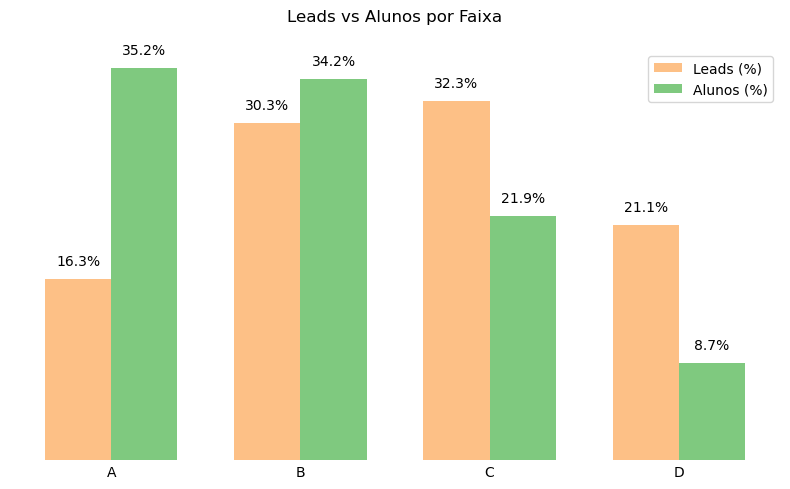

In [21]:
plot_comparativo_leads_alunos(df_leads, df_alunos)

In [22]:
# 1. Contagem por faixa
contagem = (
    df_leads.groupby(["lancamentos", "leadscore_faixa"], observed=True)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)
media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
SSP-L12,4393,16.7,8103,30.7,8492,32.2,5388,20.4,339.29
SSP-L13,1080,14.9,2098,29.0,2366,32.7,1694,23.4,330.94


In [23]:
# 1. Contagem por faixa
contagem = (
    df_alunos.groupby(["lancamentos", "leadscore_faixa"], observed=False)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)

media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
SSP-L12,69.0,35.2,67.0,34.2,43.0,21.9,17.0,8.7,339.29
SSP-L13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330.94


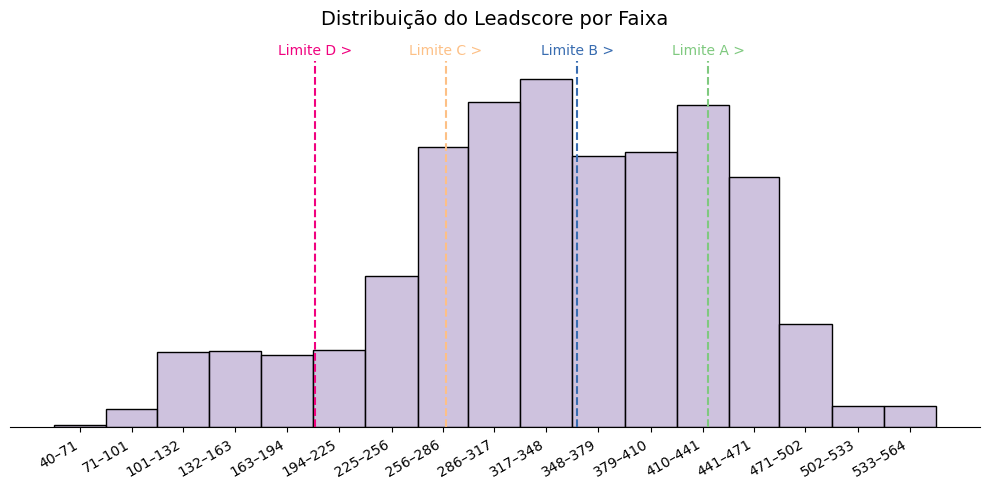

In [24]:
plot_histograma_leadscore(df_leads, limite_a, limite_b, limite_c, limite_d)

In [25]:
# Seleciona leads com faixa A ou B
leads_quentes = df_leads[df_leads["leadscore_faixa"].isin(["A", "B"])]
total_quentes = leads_quentes.shape[0]

# Quantos desses já compraram
compraram_quentes = leads_quentes["comprou"].sum()

# Resultado
print(f"Leads classificados como A ou B: {total_quentes}")
print(f"Desses, já compraram: {compraram_quentes}")
print(f"Ainda não compraram: {total_quentes - compraram_quentes}")

Leads classificados como A ou B: 15674
Desses, já compraram: 136
Ainda não compraram: 15538


In [26]:
"""
Esse bloco monta um modelo de classificação binária para prever a probabilidade de conversão de leads, com:

- Entrada: Perfil e respostas do lead
- Saída: Chance de virar aluno
- Algoritmo: Gradient Boosting
- Métrica usada: ROC AUC
"""

features_leads = [
    "renda",
    "escolaridade",
    "idade",
    "nível",
    "situação profissional"
]

# One-hot encoding
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Modelo
modelo_class = GradientBoostingClassifier(random_state=42)
modelo_class.fit(X_train, y_train)

# Avaliação
roc_auc = roc_auc_score(y_test, modelo_class.predict_proba(X_test)[:, 1])
print(f"ROC AUC (possível comprador): {roc_auc:.3f}")

# (Opcional) Score de probabilidade
df_leads["probabilidade_conversao_modelo"] = modelo_class.predict_proba(X)[:, 1]

ROC AUC (possível comprador): 0.689


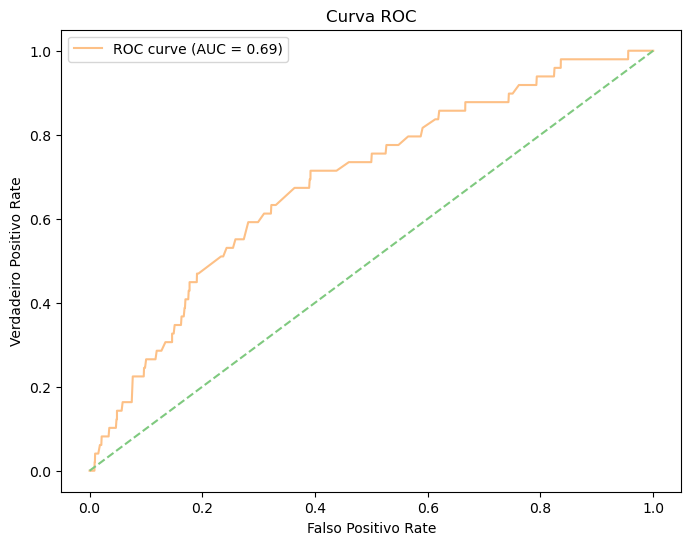

,Threshold,Precision,Recall,F1 Score
1,0.020408,0.014,0.082,0.024
0,0.000000,0.006,1.000,0.012
37,0.755102,0.000,0.000,0.000
27,0.551020,0.000,0.000,0.000
28,0.571429,0.000,0.000,0.000
29,0.591837,0.000,0.000,0.000
30,0.612245,0.000,0.000,0.000
31,0.632653,0.000,0.000,0.000
32,0.653061,0.000,0.000,0.000
33,0.673469,0.000,0.000,0.000


In [27]:
# Certifique-se de ter X_test, y_test e modelo treinado
probs = modelo_class.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, probs):.2f})", color=cores[2])
plt.plot([0, 1], [0, 1], linestyle="--", color=cores[0])
plt.xlabel("Falso Positivo Rate")
plt.ylabel("Verdadeiro Positivo Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(False)
plt.show()

# Avaliação para thresholds de 0.0 até 1.0
thresholds_to_test = np.linspace(0, 1, 50)
metrics = []

for thresh in thresholds_to_test:
    y_pred = (probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    metrics.append((thresh, precision, recall, f1))

# Mostrar tabela de avaliação
df_thresholds = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1 Score"])
df_thresholds["F1 Score"] = df_thresholds["F1 Score"].round(3)
df_thresholds["Precision"] = df_thresholds["Precision"].round(3)
df_thresholds["Recall"] = df_thresholds["Recall"].round(3)
df_thresholds.sort_values("F1 Score", ascending=False).head(10)

In [28]:
"""
Você poderá usar esse modelo para prever o score mesmo para leads que não constam no score_map ou para variáveis novas.
Também ajuda a testar consistência entre o modelo treinado e o score heurístico que você aplicou com base nos lifts.
"""

# Preparo dos dados
X_reg = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
y_reg = df_alunos["leadscore_mapeado"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, random_state=42)

# Modelo de regressão
modelo_reg = GradientBoostingRegressor(random_state=42)
modelo_reg.fit(X_train_r, y_train_r)

# Avaliação
y_pred_r = modelo_reg.predict(X_test_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
mae_pct = (mae / y_test_r.mean()) * 100

print(f"R² (leadscore_mapeado): {r2:.2f}")
print(f"Erro médio absoluto (MAE): {mae:.2f}")
print(f"MAE percentual: {mae_pct:.2f}%")

R² (leadscore_mapeado): 0.98
Erro médio absoluto (MAE): 9.68
MAE percentual: 2.40%


In [29]:
# Previsão nos leads
X_leads = pd.get_dummies(df_leads[features_alunos], drop_first=False)
X_leads = X_leads.reindex(columns=X_reg.columns, fill_value=0)

# Gerar leadscore estimado contínuo
df_leads["leadscore_regressao"] = modelo_reg.predict(X_leads).round(2)

# Visualizar os top leads por score estimado
df_leads.drop(columns=['email']).head(10)

,data,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,lancamentos,utm_source,utm_campaign,utm_medium,utm_content,comprou,leadscore_mapeado,leadscore_faixa,probabilidade_conversao_modelo,leadscore_regressao
0,2025-04-07 0:00:00,38-45,Técnica,Já sou funcionário terceirizado do sistema Pet...,De 3.000 a 5.000,Nível técnico completo,Como participar do processo seletivo,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D,ADS_006_ANUNCIO PETRO 06,0,383.00,B,0.002161,400.00
1,2025-04-07 0:00:00,38-45,Técnica,Desempregado(a),Estou desempregado(a),Nível técnico completo,Assunto específico que cai na prova?,Dificuldade em aprender!,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,0,345.89,C,0.008761,340.41
2,2025-04-07 0:00:00,28-32,Técnica,Funcionário público,De 1.000 a 3.000,Ensino médio completo,Nas perguntas,Concentração,SSP-L12,,,,,0,311.31,C,0.003138,322.47
3,2025-04-07 0:00:00,18-22,Técnica,Desempregado(a),Estou desempregado(a),Ensino médio completo,Como estudar,Constância,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_006_ANUNCIO PETRO 06,0,283.16,C,0.003584,284.05
4,2025-04-07 0:00:00,23-27,Técnica,Desempregado(a),De 1.000 a 3.000,Ensino médio completo,Qual tempo de curso,Nenhuma,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_006_ANUNCIO PETRO 06,0,362.95,B,0.006605,352.85
5,2025-04-07 0:00:00,23-27,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Nível técnico completo,Como conseguir fazer a prova pra entrar na Pet...,Falta de notebook,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D,ADS_006_ANUNCIO PETRO 06,0,476.12,A,0.010599,469.91
6,2025-04-07 0:00:00,33-37,Superior,Funcionário de empresa privada,De 1.000 a 3.000,Ensino superior incompleto,O que vai cair na prova,Saber o assunto quando eu sei o assunto eu dom...,SSP-L12,,,,,0,229.92,D,0.000978,323.88
7,2025-04-07 0:00:00,23-27,Superior,Funcionário de empresa privada,De 1.000 a 3.000,Ensino superior incompleto,Como iniciar e o que é necessário para isso !,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D,ADS_006_ANUNCIO PETRO 06,0,254.50,D,0.001387,341.08
8,2025-04-07 0:00:00,23-27,Superior,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,Como vou ser aprovado,Tempo,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D,ADS_006_ANUNCIO PETRO 06,0,283.23,C,0.001075,346.07
9,2025-04-07 0:00:00,38-45,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Nível técnico completo,Que a idade não ajuda,Concentração e tempo livre,SSP-L12,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,0,456.46,A,0.006832,452.81


In [30]:
# Validar se o modelo de regressão estima bem as faixas reais dos alunos

# 1. Copiar info de score real e faixa real
df_avaliacao = df_alunos[["email", "leadscore_mapeado", "leadscore_faixa"]].copy()

# 2. Gerar os X para regressão (features iguais às usadas no modelo)
X_alunos = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
X_alunos = X_alunos.reindex(columns=X_reg.columns, fill_value=0)

# 3. Aplicar o modelo de regressão
df_avaliacao["leadscore_regressao"] = modelo_reg.predict(X_alunos)

# 4. Classificar usando a função baseada na média dos alunos
df_avaliacao["faixa_regressao"] = df_avaliacao["leadscore_regressao"].apply(classificar_faixa)

# 5. Ver a matriz de confusão real x predita
comparativo = df_avaliacao.groupby(["leadscore_faixa", "faixa_regressao"]).size().unstack(fill_value=0)

display(comparativo)

faixa_regressao,A,B,C,D
leadscore_faixa,,,,
A,68,1,0,0
B,5,62,0,0
C,0,0,43,0
D,0,0,0,17


In [31]:
# Juntar as bases
comparacao = df_leads.merge(
    df_alunos,
    on="email",
    suffixes=("_lead", "_aluno")
)

# Verificar onde as respostas foram diferentes
mudancas = {}
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Convertendo para string para evitar erro de comparação entre categoricals com categorias diferentes
        diferentes = (comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)).sum()
        total = comparacao.shape[0]
        mudancas[var] = round((diferentes / total) * 100, 1)
    else:
        mudancas[var] = None  # Ou 0, ou continue

# Transformar em DataFrame para exibição
df_mudancas = pd.DataFrame.from_dict(mudancas, orient="index", columns=["% Respostas Diferentes"])
df_mudancas = df_mudancas.dropna().sort_values(by="% Respostas Diferentes", ascending=False)

df_mudancas

,% Respostas Diferentes
renda,0.0
escolaridade,0.0
idade,0.0
nível,0.0
situação profissional,0.0


In [32]:
# Para cada variável comum, mostrar diferenças
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Comparação como string para evitar erros com categorias
        diferentes = comparacao[comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)]
        total = comparacao.shape[0]

        print(f"\n🔍 {len(diferentes)} de {total} respostas são diferentes em '{var}'")
        display(diferentes[["email", col_lead, col_aluno]].head(10))
    else:
        print(f"\n⚠️ Coluna '{var}' não encontrada em ambos os DataFrames.")


🔍 0 de 196 respostas são diferentes em 'renda'


,email,renda_lead,renda_aluno



🔍 0 de 196 respostas são diferentes em 'escolaridade'


,email,escolaridade_lead,escolaridade_aluno



🔍 0 de 196 respostas são diferentes em 'idade'


,email,idade_lead,idade_aluno



🔍 0 de 196 respostas são diferentes em 'nível'


,email,nível_lead,nível_aluno



🔍 0 de 196 respostas são diferentes em 'situação profissional'


,email,situação profissional_lead,situação profissional_aluno


In [33]:
"""
Esse modelo é o coração da previsão de probabilidade de conversão. E ele tem duas grandes vantagens:

1. Calibração com pesos → ajuda a lidar com o desbalanceamento real
2. Integração com o score → junta perfil sociodemográfico + quão parecido o lead é com os alunos
"""

# Preparar X e y
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
X["leadscore_mapeado"] = df_leads["leadscore_mapeado"]  # Adiciona o score final como feature
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

modelo_calibrado = GradientBoostingClassifier(random_state=42)
modelo_calibrado.fit(X_train, y_train, sample_weight=sample_weight)

# Score calibrado com base nas duas fontes
df_leads["probabilidade_conversao_modelo"] = modelo_calibrado.predict_proba(X)[:, 1]

# Avaliação
print("ROC AUC:", roc_auc_score(y_test, modelo_calibrado.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, modelo_calibrado.predict(X_test)))

ROC AUC: 0.6119664382808778
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      8355
           1       0.01      0.51      0.02        49

    accuracy                           0.72      8404
   macro avg       0.50      0.62      0.43      8404
weighted avg       0.99      0.72      0.83      8404



In [34]:
# Inicializar o scaler
scaler = MinMaxScaler()

# Normalizar os dois componentes separadamente
leadscore_normalizado = scaler.fit_transform(df_leads[["leadscore_regressao"]]).flatten()
probabilidade_normalizada = scaler.fit_transform(df_leads[["probabilidade_conversao_modelo"]]).flatten()

# Pesos (ajustáveis)
peso_score = 0.5
peso_prob = 0.5

# Calcular o score híbrido como média ponderada dos valores normalizados
df_leads["score_hibrido"] = (
    peso_score * leadscore_normalizado +
    peso_prob * probabilidade_normalizada
).round(4)

# Opcional: ordenar para inspeção
df_leads = df_leads.sort_values("score_hibrido", ascending=False)

# Exibir os 10 primeiros leads rankeados
display(df_leads[["email", "leadscore_regressao", "leadscore_faixa", "probabilidade_conversao_modelo", "score_hibrido"]].drop(columns=['email']).head(10))

,leadscore_regressao,leadscore_faixa,probabilidade_conversao_modelo,score_hibrido
11891,518.84,A,0.873437,0.9455
29294,518.84,A,0.873437,0.9455
23921,518.84,A,0.873437,0.9455
20933,518.84,A,0.873437,0.9455
17635,518.84,A,0.873437,0.9455
5210,518.84,A,0.873437,0.9455
30902,518.84,A,0.873437,0.9455
1425,518.84,A,0.873437,0.9455
4389,518.84,A,0.873437,0.9455
9712,518.84,A,0.873437,0.9455


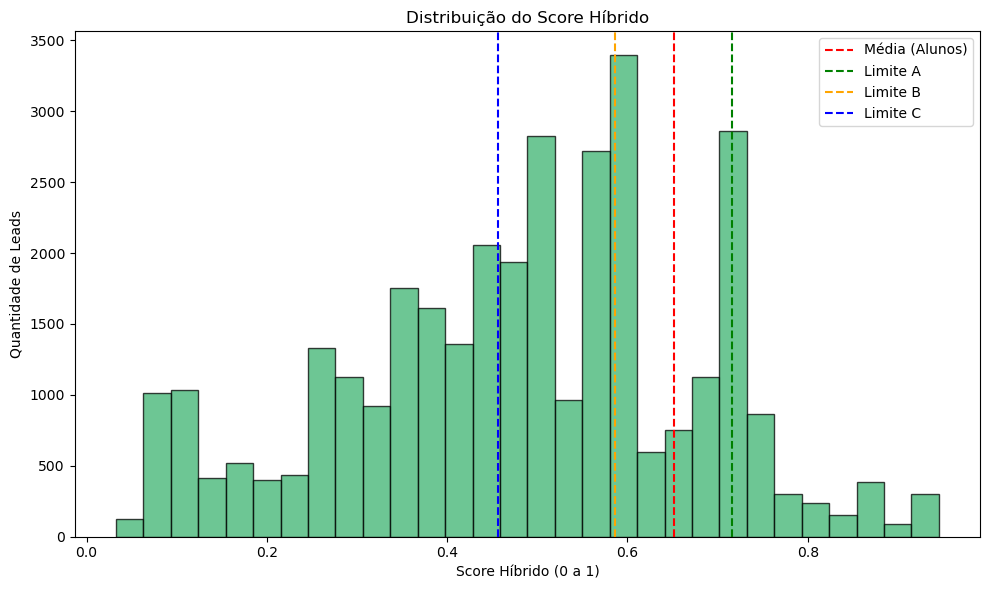

,Total Leads,Alunos,Taxa de Conversão (%)
faixa_score_hibrido,,,
A,2477,59,2.4%
B,8228,78,1.0%
C,8854,34,0.4%
D,14055,25,0.2%


In [35]:
# Base de referência: score_hibrido dos ALUNOS
media_hibrido_alunos = df_leads[df_leads["comprou"] == 1]["score_hibrido"].mean()

# Limiares baseados na média dos alunos
limite_A = media_hibrido_alunos * 1.10
limite_B = media_hibrido_alunos * 0.90
limite_C = media_hibrido_alunos * 0.70

# Função de classificação
def classificar_faixa_hibrida(score):
    if score >= limite_A:
        return "A"
    elif score >= limite_B:
        return "B"
    elif score >= limite_C:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["faixa_score_hibrido"] = df_leads["score_hibrido"].apply(classificar_faixa_hibrida)

# Plotar histograma do score_hibrido
plt.figure(figsize=(10, 6))
plt.hist(df_leads["score_hibrido"], bins=30, color="mediumseagreen", edgecolor="black", alpha=0.75)
plt.axvline(media_hibrido_alunos, color="red", linestyle="--", label="Média (Alunos)")
plt.axvline(limite_A, color="green", linestyle="--", label="Limite A")
plt.axvline(limite_B, color="orange", linestyle="--", label="Limite B")
plt.axvline(limite_C, color="blue", linestyle="--", label="Limite C")

plt.title("Distribuição do Score Híbrido")
plt.xlabel("Score Híbrido (0 a 1)")
plt.ylabel("Quantidade de Leads")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Gerar tabela de faixas com base na nova coluna faixa_score_hibrido
tabela_faixas_hibrido = (
    df_leads
    .groupby("faixa_score_hibrido")["comprou"]
    .agg(["count", "sum", "mean"])
    .rename(columns={
        "count": "Total Leads", 
        "sum": "Alunos", 
        "mean": "Taxa de Conversão"
    })
    .sort_index()
    .round(4)
)

# Formatar a taxa de conversão como string percentual
tabela_faixas_hibrido["Taxa de Conversão (%)"] = (
    tabela_faixas_hibrido["Taxa de Conversão"] * 100
).round(1).astype(str) + "%"

# Opcional: remover coluna bruta
tabela_faixas_hibrido = tabela_faixas_hibrido.drop(columns="Taxa de Conversão")

# Exibir resultado
display(tabela_faixas_hibrido)

In [36]:
# Calcular média do score híbrido por lançamento
media_hibrido_por_lancamento = (
    df_leads.groupby("lancamentos", observed=True)["score_hibrido"]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={"score_hibrido": "Probabilidade Relativa (0 - 1)"})
)

display(media_hibrido_por_lancamento)

,lancamentos,Probabilidade Relativa (0 - 1)
0,SSP-L12,0.49
1,SSP-L13,0.47


In [37]:
# Agrupamento por lançamento
tabela_lancamentos_avancada = df_leads.groupby("lancamentos", observed=True).agg(
    total_leads=("email", "count"),
    compras_reais=("comprou", "sum"),
    score_hibrido_medio=("score_hibrido", "mean"),
    probabilidade_media_modelo=("probabilidade_conversao_modelo", "mean"),
    taxa_real_conversao=("comprou", "mean")  # 0 = não comprou, 1 = comprou
).reset_index()

# Formatando colunas
tabela_lancamentos_avancada["score_hibrido_medio"] = tabela_lancamentos_avancada["score_hibrido_medio"].round(2)
tabela_lancamentos_avancada["probabilidade_media_modelo"] = (tabela_lancamentos_avancada["probabilidade_media_modelo"]).round(2)
tabela_lancamentos_avancada["taxa_real_conversao (%)"] = (tabela_lancamentos_avancada["taxa_real_conversao"] * 100).round(2)

# Selecionar colunas finais
tabela_lancamentos_avancada = tabela_lancamentos_avancada[[
    "lancamentos",
    "total_leads",
    "compras_reais",
    "taxa_real_conversao (%)",
    "probabilidade_media_modelo",
    "score_hibrido_medio"
]]

# Exibir resultado
display(tabela_lancamentos_avancada)

,lancamentos,total_leads,compras_reais,taxa_real_conversao (%),probabilidade_media_modelo,score_hibrido_medio
0,SSP-L12,26376,194,0.74,0.37,0.49
1,SSP-L13,7238,2,0.03,0.34,0.47


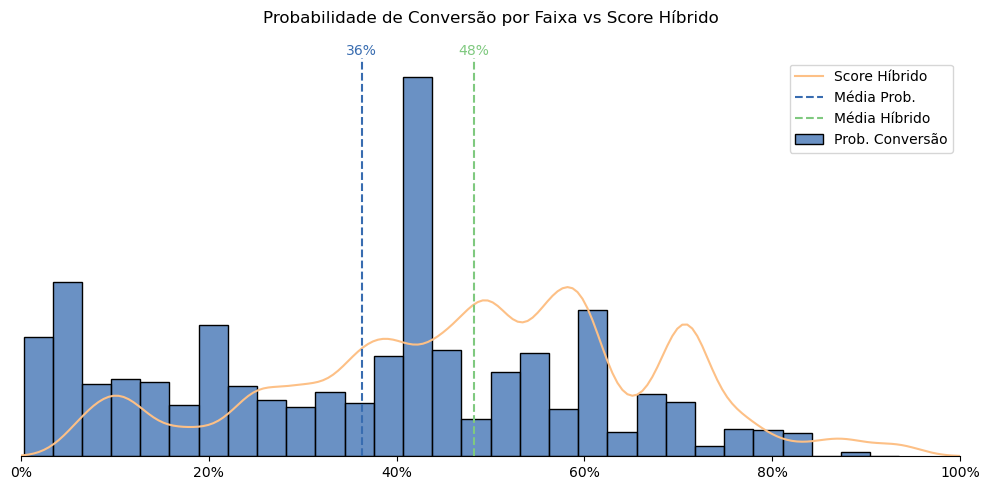

In [38]:
plot_probabilidade_conversao_vs_score(df_leads)

In [39]:
# Gerar a tabela cruzada real x predita com leads que viraram alunos
df_compare = df_leads[df_leads["email"].isin(df_alunos["email"])][["email", "faixa_score_hibrido"]]
df_compare = df_compare.merge(
    df_alunos[["email", "leadscore_faixa"]],
    on="email"
)

# Tabela cruzada: faixa real (aluno) vs faixa predita (modelo híbrido)
comparativo_faixa = pd.crosstab(df_compare["leadscore_faixa"], df_compare["faixa_score_hibrido"])

# Calcular Cramér’s V com essa matriz
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Calcular e imprimir
cramers_v_score = cramers_v(comparativo_faixa)
print(f"Cramér’s V: {cramers_v_score:.3f} (0 = sem associação, 1 = associação perfeita)")

Cramér’s V: 0.457 (0 = sem associação, 1 = associação perfeita)


In [40]:
# Caminho direto para a pasta 'modelos'
path_modelos = Path("C:/Users/Camilo_Bica/data_science/consultoria/acelerador_petrobras/modelos")
path_modelos.mkdir(parents=True, exist_ok=True)

# Média dos compradores (referência para benchmarking)
media_compradores = df_alunos["leadscore_mapeado"].mean()

# 1. Modelo de regressão para prever leadscore
joblib.dump(modelo_reg, path_modelos / "modelo_regressao_leadscore_total.pkl")
joblib.dump(X_reg.columns.tolist(), path_modelos / "colunas_regressao.pkl")

# 2. Limites para classificar em faixas A, B, C, D
limites = {
    "media_compradores": media_compradores,
    "limite_a": limite_a,
    "limite_b": limite_b,
    "limite_c": limite_c,
    "limite_d": limite_d
}
joblib.dump(limites, path_modelos / "limites_faixa.pkl")

joblib.dump(score_map, path_modelos / "score_map.pkl")

# 3. Modelo de classificação calibrado para prever conversão
joblib.dump(modelo_calibrado, path_modelos / "modelo_conversao_calibrado.pkl")
joblib.dump(X.columns.tolist(), path_modelos / "colunas_modelo_conversao_calibrado.pkl")

tabelas_lift = {}
for feature in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, feature)
    tabelas_lift[feature] = tabela

joblib.dump(tabelas_lift, path_modelos / "tabelas_lift.pkl")

# 4. Confirmação
print("✅ Modelos e arquivos de configuração exportados para:", path_modelos)

✅ Modelos e arquivos de configuração exportados para: C:\Users\Camilo_Bica\data_science\consultoria\acelerador_petrobras\modelos


In [41]:
from gspread_dataframe import set_with_dataframe
from datetime import datetime

# Carrega as variáveis de ambiente
load_dotenv()

# Pega o caminho de forma segura
credenciais_path = os.getenv("GOOGLE_CREDENTIALS_PATH")

# === Escopos de acesso ===
scopes = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

# === Autenticar ===
creds = service_account.Credentials.from_service_account_file(
    credenciais_path,
    scopes=scopes
)
client = gspread.authorize(creds)

# === Função para criar nova planilha e carregar dados ===
def criar_planilha_e_enviar(df, nome_base):
    nome_final = nome_base
    
    # Cria nova planilha
    planilha = client.create(nome_final)
    
    # Compartilha com seu e-mail pessoal (aqui você coloca o seu)
    planilha.share('camilobf2@gmail.com', perm_type='user', role='writer')  # <<< Trocar pelo seu email do Gmail

    # Preenche a primeira aba
    aba = planilha.sheet1
    aba.update_title("Dados")
    set_with_dataframe(aba, df)
    
    print(f"✅ Nova planilha criada: {nome_final}")
    print(f"🔗 Link: https://docs.google.com/spreadsheets/d/{planilha.id}/edit")

# === Geração dos arquivos ===
#criar_planilha_e_enviar(df_alunos, "leadscore_implementado")

In [42]:
# === Função para atualizar uma planilha existente ===
def atualizar_planilha_existente(df: pd.DataFrame, sheet_id: str, aba_nome: str = "Dados"):
    """
    Atualiza uma aba específica de uma planilha no Google Sheets.
    
    - df: DataFrame com os dados que serão enviados
    - sheet_id: ID da planilha (o que vem na URL depois de "/d/")
    - aba_nome: Nome da aba que será atualizada (default: 'Dados')
    """
    try:
        planilha = client.open_by_key(sheet_id)
        try:
            aba = planilha.worksheet(aba_nome)
        except gspread.WorksheetNotFound:
            aba = planilha.add_worksheet(title=aba_nome, rows="1000", cols="20")
        
        aba.clear()  # Limpa dados antigos
        set_with_dataframe(aba, df)
        
        print(f"✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/{sheet_id}/edit")
    except Exception as e:
        print(f"❌ Erro ao atualizar a planilha: {e}")

# === IDs das planilhas (FIXOS, preencha certinho aqui) ===
id_leads = "1otpSf30y2iqykxNNiCmN3DjxVDTuHSVZhOpzwi8UBBc"
id_alunos = "15RQf1wkiafPZftolCIAwcTFE7rv0_zRTB0zDOCkdPRs"

# === Atualizar todas as planilhas ===
atualizar_planilha_existente(df_leads, id_leads)
atualizar_planilha_existente(df_alunos, id_alunos)

✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/1otpSf30y2iqykxNNiCmN3DjxVDTuHSVZhOpzwi8UBBc/edit


✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/15RQf1wkiafPZftolCIAwcTFE7rv0_zRTB0zDOCkdPRs/edit
